In [1]:
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from tempfile import TemporaryFile
import os
import math
import pickle
import random
import operator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,roc_curve, roc_auc_score,auc
#from sklearnex.metrics import confusion_matrix, classification_report, accuracy_score,roc_curve, roc_auc_score,auc
from sklearn.preprocessing import label_binarize
import collections as collections

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Define the distance function
def distance(instance1, instance2, k):
    distance = 0
    mm1 = instance1[0]
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    distance += (np.dot(np.dot((mm2-mm1).transpose(), np.linalg.inv(cm2)), mm2-mm1))
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k
    return distance

In [3]:
# Define the getNeighbors function
def getNeighbors(trainingset, instance, k):
    distances = []
    for x in range(len(trainingset)):
        dist = distance(trainingset[x], instance, k) + distance(instance,trainingset[x],k)
        distances.append((trainingset[x][2], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [4]:
# Define the nearestclass function
def nearestclass(neighbors):
    classVote = {}
    
    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1
            
    sorter = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    return sorter[0][0]


In [5]:
# Set the directory path to the audio files

directory = 'genres_original'

In [6]:
# Define the function to load the dataset and split it into training and test sets
def loadDataset(filename, split):
    dataset = []
    with open(filename, 'rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    trainingSet = []
    testSet = []
    for x in range(len(dataset)):
        if random.random() < split:
            trainingSet.append(dataset[x])
        else:
            testSet.append(dataset[x])
    return trainingSet, testSet

In [7]:
# Load the dataset and split it into training and test sets
def load_dataset(directory):
    f = open("my.dat", "wb")
    i = 0
    results = collections.defaultdict(int)
    for folder in os.listdir(directory):
        i += 1
        results[i] = folder
        for file in os.listdir(directory + "/" + folder):
            try:
                (rate, sig) = wav.read(directory + "/" + folder + "/" + file)
                mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False)
                covariance = np.cov(np.matrix.transpose(mfcc_feat))
                mean_matrix = mfcc_feat.mean(0)
                feature = (mean_matrix, covariance, i)
                pickle.dump(feature, f)
            except Exception as e:
                print("Got an exception: ", e, 'in folder: ', folder, ' filename: ', file)
                continue
    f.close()
    return results

results = load_dataset(directory)

results = load_dataset(directory)

Got an exception:  File format b'\xcb\x15\x1e\x16' not understood. Only 'RIFF' and 'RIFX' supported. in folder:  jazz  filename:  jazz.00054.wav
Got an exception:  File format b'\xcb\x15\x1e\x16' not understood. Only 'RIFF' and 'RIFX' supported. in folder:  jazz  filename:  jazz.00054.wav


In [8]:
# Calculate the distance between two instances
def calculate_distance(instance1, instance2, k):
    distance = 0
    mm1 = instance1[0]
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    distance += (np.dot(np.dot((mm2-mm1).transpose(), np.linalg.inv(cm2)), mm2-mm1))
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k
    return distance

In [9]:
# Calculate the accuracy for a given k value
def calculate_accuracy(k, trainingSet, testSet):
    predictions = []
    for x in range(len(testSet)):
        neighbors = getNeighbors(trainingSet, testSet[x], k)
        result = nearestclass(neighbors)
        predictions.append(result)
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][2] == predictions[x]:
            correct += 1
    return (correct / float(len(testSet))) * 100.0

In [10]:
# Calculate the accuracy for different k values
def evaluate_k_values(k_values, trainingSet, testSet):
    accuracies = []
    for k in k_values:
        accuracy = calculate_accuracy(k, trainingSet, testSet)
        accuracies.append(accuracy)
        print(f'k = {k}, Accuracy: {accuracy:.2f}%')
    return accuracies

In [11]:
# Plot the elbow graph
def plot_elbow_graph(k_values, accuracies):
    plt.plot(k_values, accuracies, marker='o')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title('Elbow Graph')
    plt.show()

k = 1, Accuracy: 65.98%
k = 2, Accuracy: 65.98%
k = 3, Accuracy: 67.01%
k = 4, Accuracy: 64.95%
k = 5, Accuracy: 64.95%
k = 6, Accuracy: 62.89%
k = 7, Accuracy: 62.89%
k = 8, Accuracy: 62.89%
k = 9, Accuracy: 64.95%


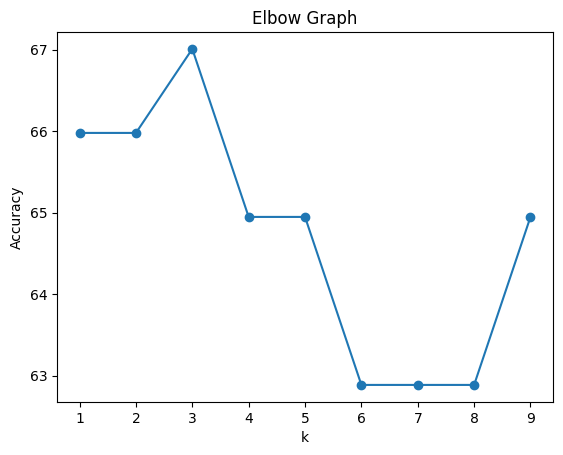

Best k value: 3
Best accuracy: 67.01%

Confusion Matrix:
[[9 0 0 0 0 3 0 0 0 0]
 [0 4 1 0 0 0 5 0 1 0]
 [0 1 7 0 0 0 0 1 1 0]
 [0 0 0 6 0 0 0 1 0 0]
 [0 1 1 0 4 0 0 0 1 0]
 [0 0 0 0 1 7 0 1 0 0]
 [0 0 1 1 0 0 4 3 0 0]
 [0 0 0 1 0 0 0 8 0 0]
 [0 0 1 1 0 0 2 1 7 2]
 [0 0 0 0 0 0 0 0 0 9]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.75      0.86        12
           2       0.67      0.36      0.47        11
           3       0.64      0.70      0.67        10
           4       0.67      0.86      0.75         7
           5       0.80      0.57      0.67         7
           6       0.70      0.78      0.74         9
           7       0.36      0.44      0.40         9
           9       0.53      0.89      0.67         9
          10       0.70      0.50      0.58        14
          11       0.82      1.00      0.90         9

    accuracy                           0.67        97
   macro avg       0.69      0.69     

In [12]:
# Define the range of k values to test
k_values = range(1, 10)
# Load the dataset and split it into training and test sets
trainingSet, testSet = loadDataset('my.dat', 0.90)

# Evaluate different k values
accuracies = evaluate_k_values(k_values, trainingSet, testSet)

# Plot the elbow graph
plot_elbow_graph(k_values, accuracies)

# Find the best k value
best_k = k_values[np.argmax(accuracies)]
best_accuracy = accuracies[np.argmax(accuracies)]
print(f"Best k value: {best_k}")
print(f"Best accuracy: {best_accuracy:.2f}%")

# Calculate confusion matrix for the best k value
predictions = []
for x in range(len(testSet)):
    neighbors = getNeighbors(trainingSet, testSet[x], best_k)
    result = nearestclass(neighbors)
    predictions.append(result)

actual_labels = [instance[2] for instance in testSet]
confusion_mat = confusion_matrix(actual_labels, predictions)

# Calculate precision, recall, and F1-score from the confusion matrix
report = classification_report(actual_labels, predictions)
accuracy = accuracy_score(actual_labels, predictions)

# Print the confusion matrix, precision, recall, and F1-score
print("\nConfusion Matrix:")
print(confusion_mat)
print("\nClassification Report:")
print(report)
print("\nAccuracy:", accuracy)

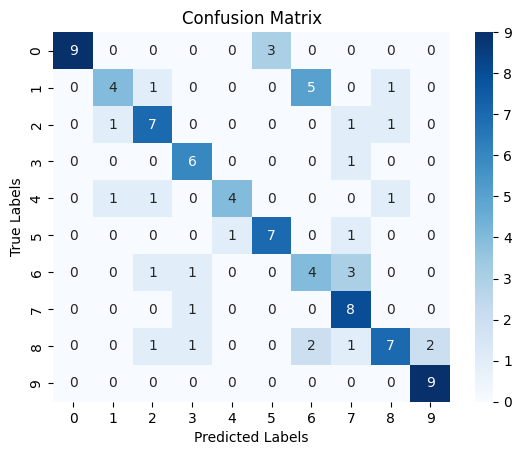

In [13]:
# Print the confusion matrix graphically
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


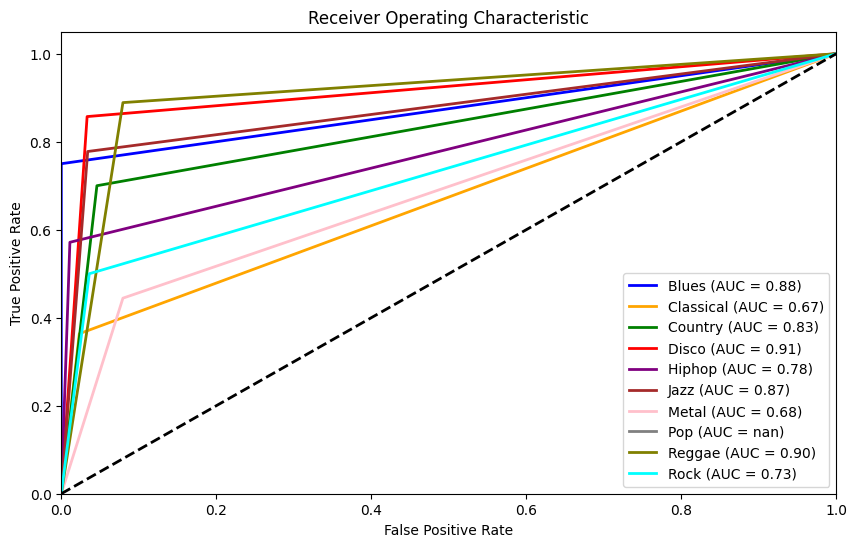

In [14]:
genre_names = [
    'Blues', 'Classical', 'Country', 'Disco', 'Hiphop',
    'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock'
]

# Get the predicted probabilities for each class
probabilities = []
for x in range(len(testSet)):
    neighbors = getNeighbors(trainingSet, testSet[x], best_k)
    class_probabilities = [1 if i == nearestclass(neighbors) else 0 for i in range(1, 11)]
    probabilities.append(class_probabilities)

# Binarize the actual labels
actual_labels = [instance[2] for instance in testSet]
binarized_labels = label_binarize(actual_labels, classes=[i for i in range(1, 11)])

# Calculate the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], np.array(probabilities)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i in range(10):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label='%s (AUC = %0.2f)' % (genre_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
# Get the user-given test sample (audio file or data)
# Replace 'user_test_sample.wav' with the path to the user's test sample
test_file = 'genres_original/hiphop/hiphop.00057.wav'
(rate, sig) = wav.read(test_file)
test_mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False)
test_covariance = np.cov(np.matrix.transpose(test_mfcc_feat))
test_mean_matrix = test_mfcc_feat.mean(0)
test_instance = (test_mean_matrix, test_covariance)

# Predict the genre of the user's test sample
neighbors = getNeighbors(trainingSet, test_instance, best_k)
predicted_genre = nearestclass(neighbors)

print("Predicted Genre:", results[predicted_genre])

Predicted Genre: hiphop
